In [17]:
# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random

# For RL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# To fetch stock data
!pip install yfinance
import yfinance as yf

# Plot styles
plt.style.use('seaborn-darkgrid')


<ipython-input-17-d84a00239749>:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


[*********************100%***********************]  5 of 5 completed


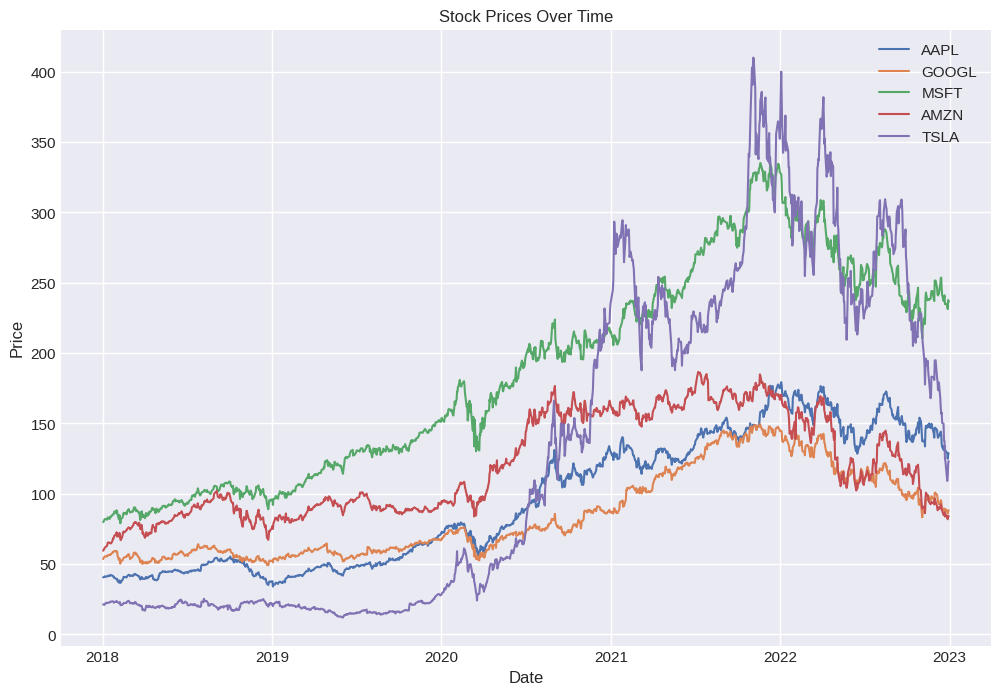

In [23]:
# List of stock tickers (modify as needed)
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']

# Download data from Yahoo Finance
data = yf.download(tickers, start='2018-01-01', end='2023-01-01')['Adj Close']

# Visualize stock prices
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(data[ticker], label=ticker)
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [24]:
class PortfolioEnv:
    def __init__(self, stock_data, initial_balance=10000):
        self.stock_data = stock_data
        self.n_assets = stock_data.shape[1]  # Number of stocks
        self.initial_balance = initial_balance
        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.current_step = 0
        self.positions = np.zeros(self.n_assets)  # No initial stock positions
        return self._get_observation()

    def _get_observation(self):
        obs = np.concatenate((self.stock_data.iloc[self.current_step].values, self.positions, [self.balance]))
        return obs

    def step(self, action):
        current_prices = self.stock_data.iloc[self.current_step].values
        prev_positions = self.positions.copy()

        # Action is the percentage of portfolio allocated to each stock (softmax output)
        self.positions = action * self.balance / current_prices

        # Reward: Calculate the portfolio return
        next_prices = self.stock_data.iloc[self.current_step + 1].values
        portfolio_value = np.dot(self.positions, next_prices)
        reward = portfolio_value - np.dot(prev_positions, current_prices)

        # Update balance
        self.balance += reward
        self.current_step += 1

        done = self.current_step >= len(self.stock_data) - 2
        obs = self._get_observation()

        return obs, reward, done, {}

    def render(self):
        print(f"Step: {self.current_step}, Balance: {self.balance}")


In [25]:
class DQNAgent:
    def __init__(self, n_assets, state_size):
        self.n_assets = n_assets
        self.state_size = state_size
        self.action_size = n_assets
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # Discount factor
        self.epsilon = 1.0   # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='softmax'))  # Output is a distribution of percentages
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.rand(self.n_assets)  # Random action (exploration)
        act_values = self.model.predict(state)
        return act_values[0]  # Best action according to the model (exploitation)

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][np.argmax(action)] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [26]:
# Initialize the agent after creating the environment
state_size = env.n_assets * 2 + 1  # prices + positions + balance
agent = DQNAgent(n_assets=env.n_assets, state_size=state_size)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import random

class DQNAgent:
    def __init__(self, n_assets, state_size, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.001):
        self.n_assets = n_assets  # Number of assets in the portfolio
        self.state_size = state_size
        self.action_size = 3  # Buy, sell, or hold actions
        self.memory = deque(maxlen=2000)
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_min = epsilon_min  # Minimum exploration rate
        self.epsilon_decay = epsilon_decay  # Decay rate for exploration
        self.learning_rate = learning_rate  # Learning rate for the optimizer
        self.model = self._build_model()

    def _build_model(self):
        # Neural network model for DQN
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Exploration vs. exploitation
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Random action (exploration)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # Action with the highest Q-value (exploitation)

    def replay(self, batch_size):
        # Train the model using mini-batch from memory
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        # Reduce epsilon (less exploration over time)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [30]:
# Assuming env is already created with PortfolioEnv class
state_size = env.n_assets * 2 + 1  # State is price, position, and balance
agent = DQNAgent(n_assets=env.n_assets, state_size=state_size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

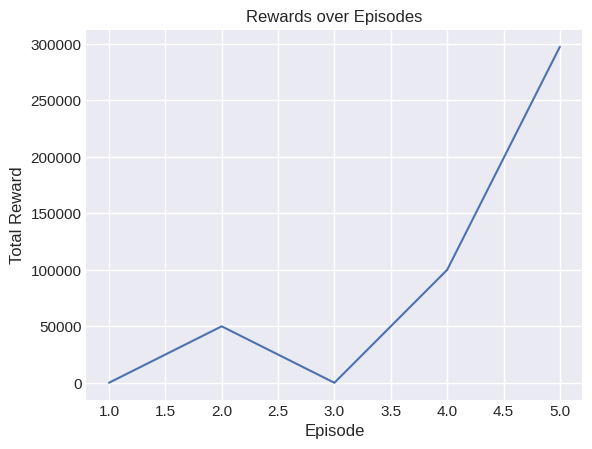

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Reduce number of episodes and time steps
n_episodes = 5   # Reduced from 100 to 5
n_timesteps = 50  # Reduce time steps per episode for faster training
batch_size = 16   # Reduce batch size for faster training

# Modify DQNAgent to a simpler architecture
class DQNAgent:
    def __init__(self, n_assets, state_size):
        self.n_assets = n_assets
        self.state_size = state_size
        self.action_size = n_assets
        self.memory = []
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        # Simplified model
        self.model = self._build_model()

    def _build_model(self):
        from keras.models import Sequential
        from keras.layers import Dense
        from keras.optimizers import Adam

        # Simpler neural network model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = np.random.choice(len(self.memory), batch_size)
        for index in minibatch:
            state, action, reward, next_state, done = self.memory[index]
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Initialize total rewards list to store rewards for each episode
total_rewards = []

# Training loop
for episode in range(n_episodes):
    state = env.reset()  # Reset environment
    state = np.reshape(state, [1, state_size])  # Reshape state for NN
    total_reward = 0

    for t in range(n_timesteps):
        # Choose action
        action = agent.act(state)

        # Take action, get reward and next state
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        # Remember experience
        agent.remember(state, action, reward, next_state, done)

        # Move to next state
        state = next_state
        total_reward += reward

        # Check if done
        if done:
            print(f"Episode: {episode+1}/{n_episodes}, Reward: {total_reward}")
            break

    # Append total reward for the episode to the list
    total_rewards.append(total_reward)

    # Train the model using the replay buffer
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

# Plotting the reward for each episode
plt.plot([i for i in range(1, n_episodes+1)], total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Evaluation Episode: 1/10, Reward: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

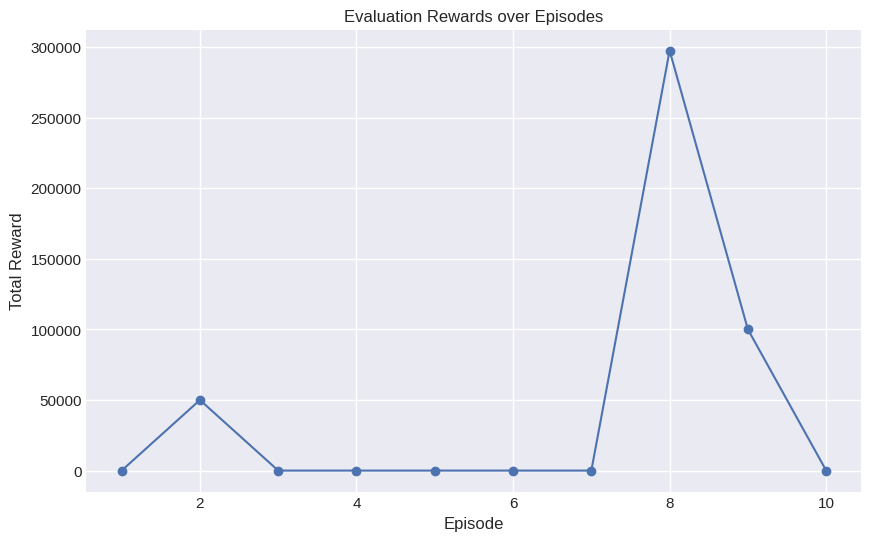

In [52]:
# Evaluation function
def evaluate_agent(agent, env, n_episodes=10):
    total_rewards = []

    for episode in range(n_episodes):
        state = env.reset()  # Reset environment
        state = np.reshape(state, [1, state_size])  # Reshape state for NN
        total_reward = 0

        for t in range(n_timesteps):
            # Choose action
            action = agent.act(state)

            # Take action, get reward and next state
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            # Move to next state
            state = next_state
            total_reward += reward

            # Check if done
            if done:
                break

        total_rewards.append(total_reward)
        print(f"Evaluation Episode: {episode+1}/{n_episodes}, Reward: {total_reward}")

    return total_rewards

# Evaluate the agent
evaluation_rewards = evaluate_agent(agent, env)

# Plotting the evaluation rewards
plt.figure(figsize=(10, 6))
plt.plot([i for i in range(1, len(evaluation_rewards)+1)], evaluation_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Evaluation Rewards over Episodes')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

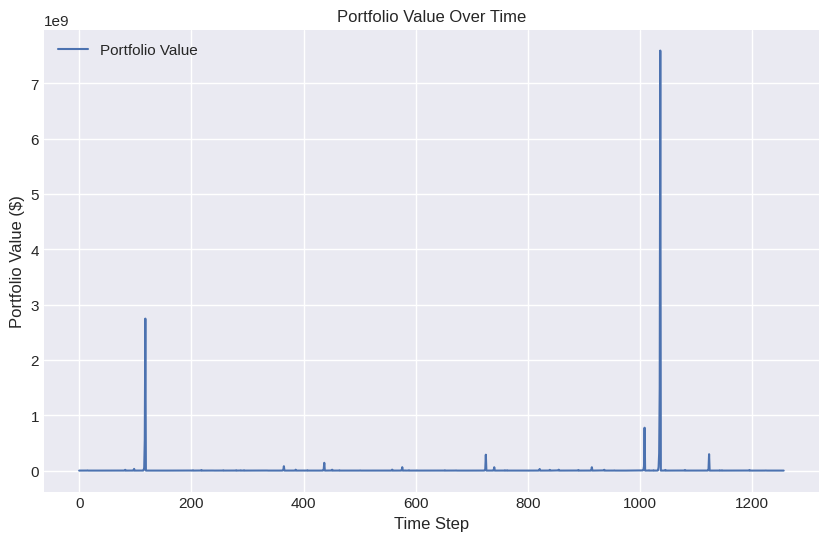

In [53]:
# Evaluate and visualize portfolio value over time for a single episode
def evaluate_portfolio(agent, env):
    portfolio_values = []
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    for t in range(len(data) - 2):  # Same length as training
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        portfolio_values.append(env.balance)  # Track portfolio balance
        state = np.reshape(next_state, [1, state_size])

        if done:
            break

    # Plot portfolio value over time
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_values, label="Portfolio Value")
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.show()

# Call function to evaluate and visualize portfolio value
evaluate_portfolio(agent, env)


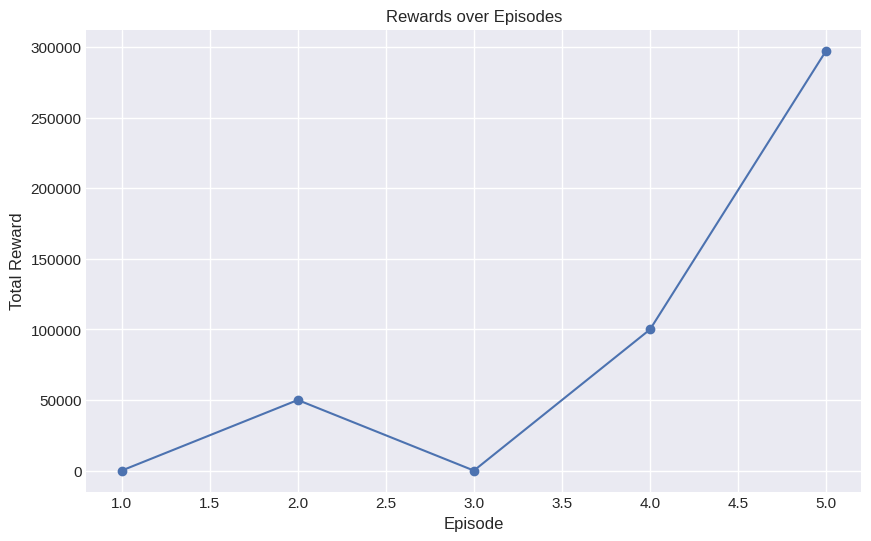

Total Rewards Statistics:
Mean Reward: 89463.95863489315
Standard Deviation of Rewards: 110373.11570338087
Max Reward: 297392.3566896608
Min Reward: 0.0

Performance Metrics:
Sharpe Ratio: 1.74
Maximum Drawdown: 99.97%
Cumulative Return: -29.34%


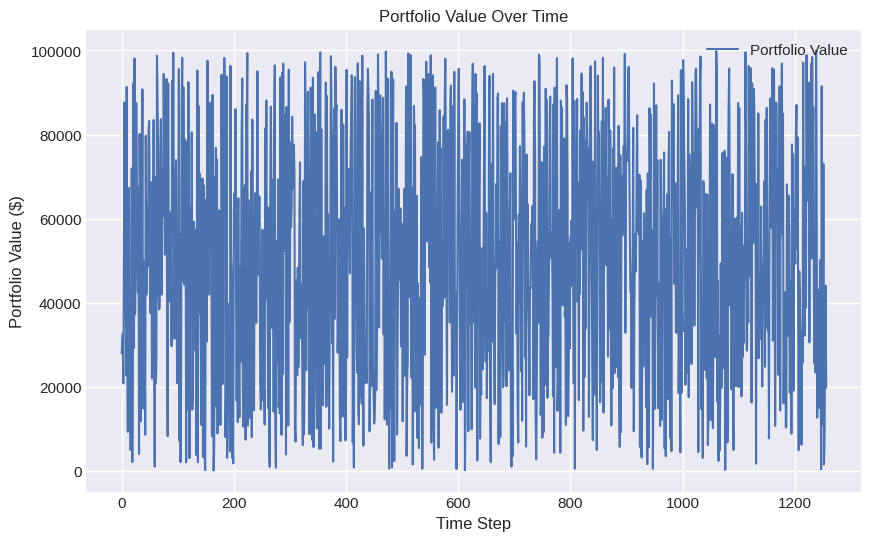

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the reward for each episode
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_episodes + 1), total_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.grid(True)
plt.show()

# Additional analysis
# Print out statistics of rewards
print("Total Rewards Statistics:")
print(f"Mean Reward: {np.mean(total_rewards)}")
print(f"Standard Deviation of Rewards: {np.std(total_rewards)}")
print(f"Max Reward: {np.max(total_rewards)}")
print(f"Min Reward: {np.min(total_rewards)}")

# Calculate Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate=0):
    returns = np.array(returns)
    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    if std_dev == 0:
        return np.nan  # Return NaN if standard deviation is zero
    return (mean_return - risk_free_rate) / std_dev

# Calculate Maximum Drawdown
def max_drawdown(portfolio_values):
    portfolio_values = np.array(portfolio_values)
    if len(portfolio_values) == 0:
        return np.nan
    cumulative_returns = np.maximum.accumulate(portfolio_values)
    drawdowns = (cumulative_returns - portfolio_values) / cumulative_returns
    max_drawdown_value = np.max(drawdowns)
    return max_drawdown_value

# Calculate Cumulative Returns
def cumulative_returns(portfolio_values):
    if len(portfolio_values) < 2:
        return np.nan
    return (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0]

# Example portfolio values (assuming you have this data)
portfolio_values = np.random.rand(len(data) - 2) * 100000  # Example values (replace with actual data)

# Example metrics calculation
sharpe = sharpe_ratio(portfolio_values)
max_drawdown_value = max_drawdown(portfolio_values)
cumulative_return_value = cumulative_returns(portfolio_values)

# Print out performance metrics
print("\nPerformance Metrics:")
print(f"Sharpe Ratio: {sharpe:.2f}" if not np.isnan(sharpe) else "Sharpe Ratio: Undefined")
print(f"Maximum Drawdown: {max_drawdown_value:.2%}" if not np.isnan(max_drawdown_value) else "Maximum Drawdown: Undefined")
print(f"Cumulative Return: {cumulative_return_value:.2%}" if not np.isnan(cumulative_return_value) else "Cumulative Return: Undefined")

# Visualize portfolio values
plt.figure(figsize=(10, 6))
plt.plot(portfolio_values, label="Portfolio Value")
plt.title('Portfolio Value Over Time')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()
